# Search Evaluation Notebook

This python notebook will perform a search evaluation 
Prerequisites:
* Golden data set in file ```golden_data.csv```
* Search strategies in python modules located in the ```strategies``` folder

In [ ]:
import requests
from io import StringIO
from dotenv import load_dotenv
import os, subprocess

# Export the API key to an environment variable
if not os.path.exists('.env.instruqt'):
    env_text = requests.get('http://kubernetes-vm:9000/env').text
    with open('.env.instruqt', 'w') as f:
        f.write(env_text)
load_dotenv('.env.instruqt')

openai_api_key =  os.environ.get("LLM_APIKEY") 
url = os.environ.get("LLM_PROXY_URL") 
openai_api_base = f"https://{url}"

os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["OPENAI_BASE_URL"] = openai_api_base

subprocess.run([
    "deepeval", "set-local-model", 
    "--model-name=eval-gpt-4o", ## needs azure 2024-11-20 +
    f"--base-url={openai_api_base}", 
    f"--api-key={openai_api_key}"
    f""])

# # # ## Uncomment the following lines if you want to use .env file to control settings
# load_dotenv()   


True

In [2]:
### What files to work with
GOLDEN_DATA_CSV = "wikivoyage_judgement_list.csv"
STRATEGIES_FOLDER = "strategies"
SEARCH_OUTPUT_JSON = "results_search_evaluation.json"
DEEPEVAL_OUTPUT_JSON = "results_deepeval_results.json"

In [3]:
## Run the Evaluation

from utility.util_es import get_es
from utility.util_vis_result import vis_search_eval_json, vis_deep_eval_correct_tests
from evaluate import run_search_evaluation, load_golden_data, load_strategies, output_search_eval_results

# https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html
print("### Starting evaluation using Elasticsearch _rank_eval API")

# 1. Connect to Elasticsearch
es = get_es()
print(f"\tConnected to Elasticsearch version: {es.info()['version']['number']}")

# 2. Load the golden data set
golden_data = load_golden_data(GOLDEN_DATA_CSV)
print(f"\tIdentified {len(golden_data)} golden data entry(ies) to use for search evaluation")

# 3. Load strategies from the strategies folder
strategy_modules = load_strategies(STRATEGIES_FOLDER)  
print(f"\tIdentified {len(strategy_modules)} strategy(ies) to evaluate")

# 4. Evaluate each strategy
results = run_search_evaluation(es, golden_data, strategy_modules)

# 5. Output the evaluation results
output_search_eval_results(SEARCH_OUTPUT_JSON, results, golden_data, strategy_modules)



Using ES with configured Host and API key ...


/Users/dave/dev/instruqt_cert_module6/genai-workshops/.venv/lib/python3.13/site-packages/deepeval/__init__.py:53: UserWarning: You are using deepeval version 2.4.7, however version 2.6.5 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


### Starting evaluation using Elasticsearch _rank_eval API
	Connected to Elasticsearch version: 8.17.4
	Identified 9 golden data entry(ies) to use for search evaluation
	Identified 5 strategy(ies) to evaluate
### SEARCH RANK EVAL
	Starting strategy: 1_default_bm25
	Starting strategy: 2_filtered_bm25
	Starting strategy: 4_e5
	Starting strategy: 5_e5_rrf
	Starting strategy: 7_post_reranker
[LLMRagCache] Error: Could not persist cache to disk: [Errno 2] No such file or directory: './.cache/rag_cache.json'
[QueryTransformCache] Error: Could not persist cache to disk: [Errno 2] No such file or directory: './.cache/transform_cache.json'
### Evaluation complete. 
	Results written to  results_search_evaluation.json


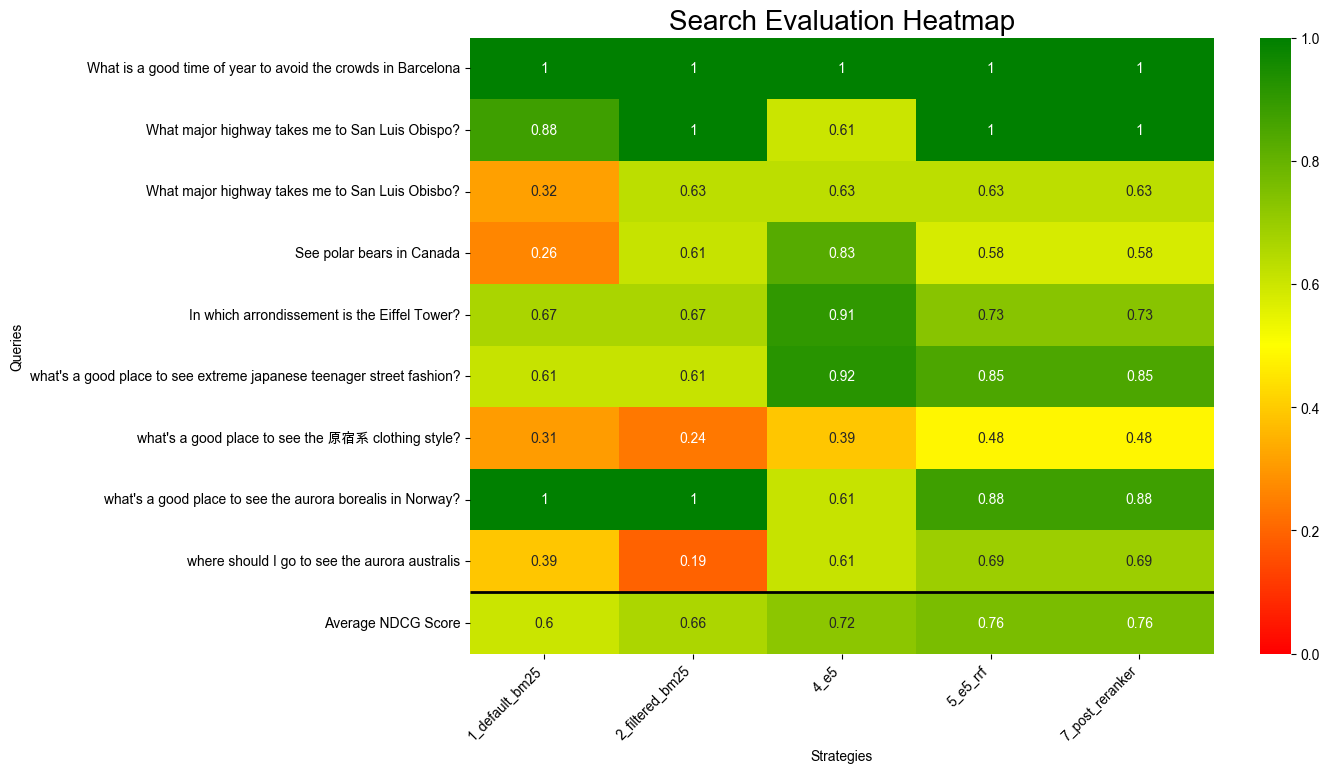

In [4]:
## Visualize the Results of the Evaluation
# 6. Visualize
vis_search_eval_json(SEARCH_OUTPUT_JSON)

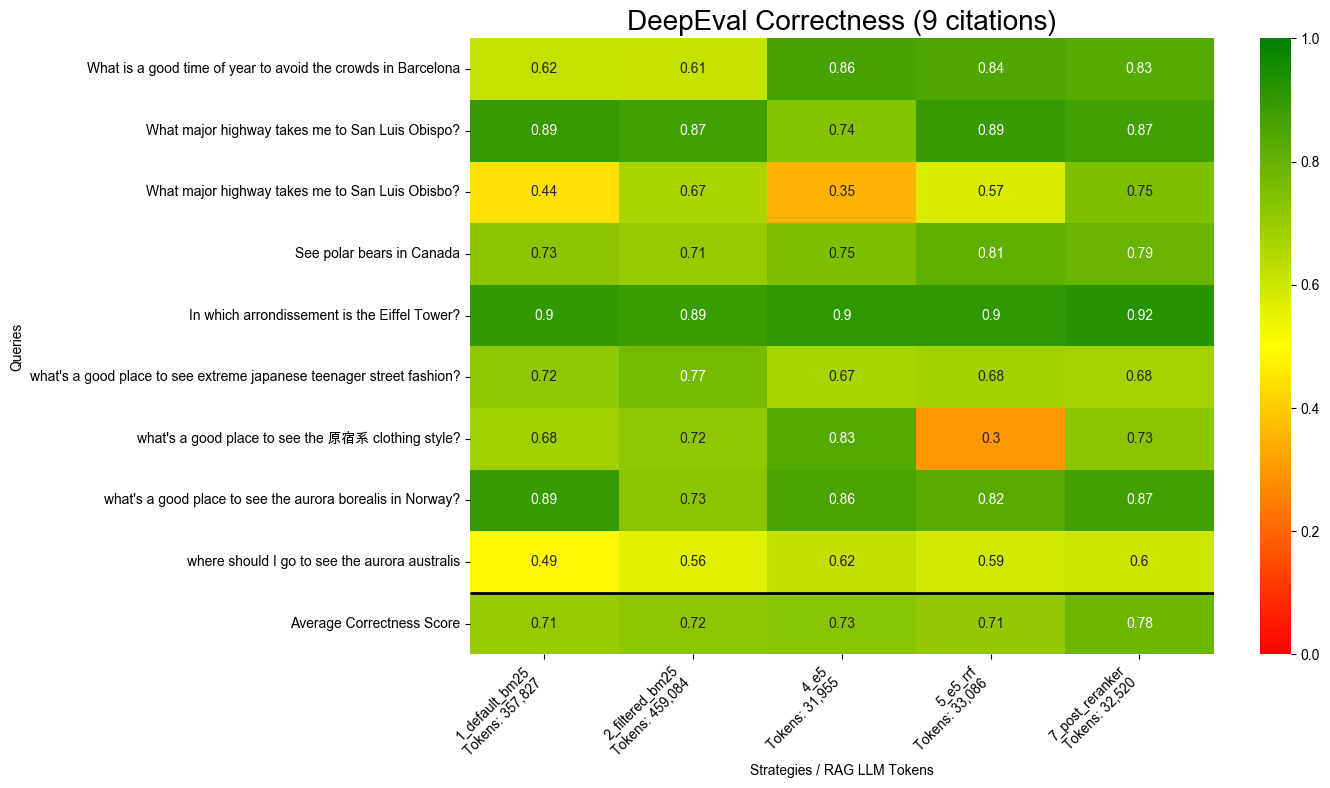

In [6]:
from evaluate import run_deepeval, output_deepeval_results

import json

# startegies to Evauate
# include_strategy_names = ["3b_e5_hybrid", "3b_e5_hybrid_qt"]


## Deep Eval Evaluation
print("### DEEP EVAL")
es = get_es()

rag_system_prompt = """
Instructions:

- You are an assistant for question-answering tasks.
- Answer questions truthfully and factually using only the context presented.
- Do not jump to conclusions or make assumptions.
- If the answer is not present in the provided context, just say that you don't know rather than making up an answer or using your own knowledge from outside the prompt.
- You must always cite the document where the answer was extracted using inline academic citation style [], using the position or multiple positions. Example:  [1][3].
- Use markdown format for code examples or bulleted lists.
- You are correct, factual, precise, and reliable.


Context:
{context}
"""

citations_max = 9  ### <--- reducing the number of sub-document citiations shows the value of ranking to RAG (3 hard, 9 easy)

## Search Top 6 documents, with 3 inner hits per doc, send a max of X citations to the LLM for RAG
deepEvalScores = run_deepeval(es, strategy_modules, golden_data, rag_system_prompt,6, 3, citations_max)


## save the scores to disk
output_deepeval_results(DEEPEVAL_OUTPUT_JSON, deepEvalScores)
print(f"\nDeepEval scores saved to {DEEPEVAL_OUTPUT_JSON}")
# Visualize
vis_deep_eval_correct_tests(DEEPEVAL_OUTPUT_JSON, f"DeepEval Correctness ({citations_max} citations)")


